In [3]:
import pandas as ps
import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
import fiona
import shapefile
import os, sys, csv, re
import shapely.geometry

import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf


from scipy.stats import zscore
from scipy.interpolate import make_interp_spline, BSpline

In [4]:
# base_dir = r"D:\Acadamics\University\Year_3\Sem_2\GIS3005 - Remote Sensing\Assignment\1"
base_dir = os.getcwd()
nightlight = os.path.join(base_dir, r"nightlight.csv")
gdp_dataset_filtered = os.path.join(base_dir, r"GDP\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391_filtered.csv")
countries_interested = ["Pakistan", "Nepal", "Sri Lanka", "India", "Bhutan", "Bangladesh"]

In [5]:
def predict(train_x, train_y, test_x, test_y):

    # # Normalize the input data
    # train_x = (train_x.reshape(-1, 1)[:,1:] - np.mean(train_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(train_x.reshape(-1, 1)[:,1:], axis=0)
    # test_x = (test_x.reshape(-1, 1)[:,1:] - np.mean(test_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(test_x.reshape(-1, 1)[:,1:], axis=0)

    # model = tf.keras.Sequential()
    # model.compile(optimizer='sgd', loss='mean_squared_error')
    # model.fit(train_x, train_y, epochs=500)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(train_x.reshape(-1, 1))
    y_scaled = scaler.fit_transform(train_y.reshape(-1, 1))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Train the model
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

    # Evaluate the model
    model.evaluate(X_val, y_val)

    # Make predictions
    new_X_scaled = scaler.transform(test_x.reshape(-1, 1))
    predictions = model.predict(new_X_scaled)
    
    return predictions

In [6]:
from matplotlib.ticker import FuncFormatter

def plot_(_cnl, _cgdp, _years, country):
    
    formatter = FuncFormatter(billions)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Years')
    ax1.set_ylabel('GDP', color=color)
    ax1.plot(_years, _cgdp, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_formatter(formatter)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('NightLight', color=color)  # we already handled the x-label with ax1
    ax2.plot(_years, _cnl, color=color, marker='h')
    ax2.tick_params(axis='y', labelcolor=color)

    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # plt.grid()
    plt.title(country)
    plt.show()

In [7]:
def billions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1f B' % (x * 1e-9)

In [8]:
from_year = 1992
to_year = 2013

In [34]:
gdp = ps.read_csv(gdp_dataset_filtered, skiprows=0)
nl = ps.read_csv(nightlight, skiprows=0)
gdp = gdp.set_index('Name')
nl = nl.set_index('country')
print(nl.head())
# print(gdp.head())

          Unnamed: 0  year  nightlight
country                               
Pakistan           0  1992    4.333373
Pakistan           1  1993    4.318844
Pakistan           2  1994    4.388912
Pakistan           3  1995    4.496202
Pakistan           4  1996    4.468319


Country Pakistan: gdp 48884606848.1265 231218567178.979 | nl 4.31884407427173 5.510340071336126


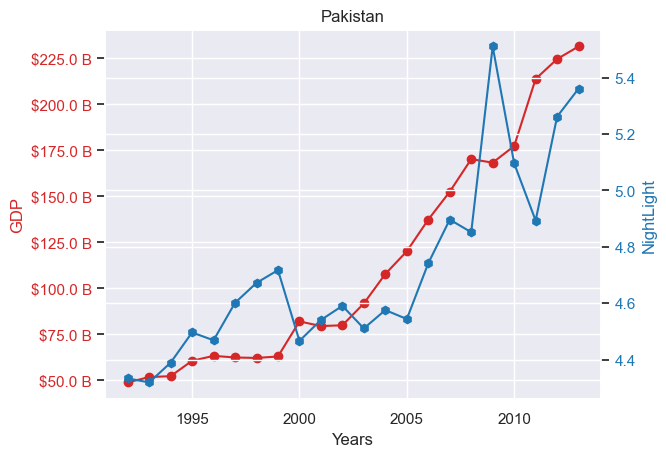

Country Nepal: gdp 3401211581.29176 22162208956.1412 | nl 3.3639899046137653 4.876026696116584


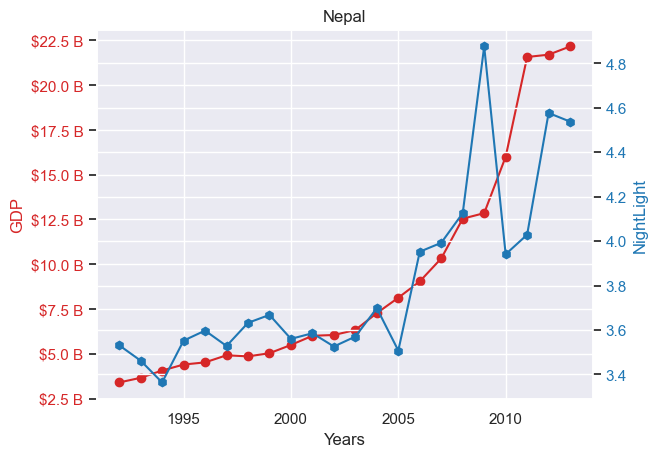

Country Sri Lanka: gdp 9703011635.86585 77000596661.4756 | nl 4.022293367098456 5.449756286891084


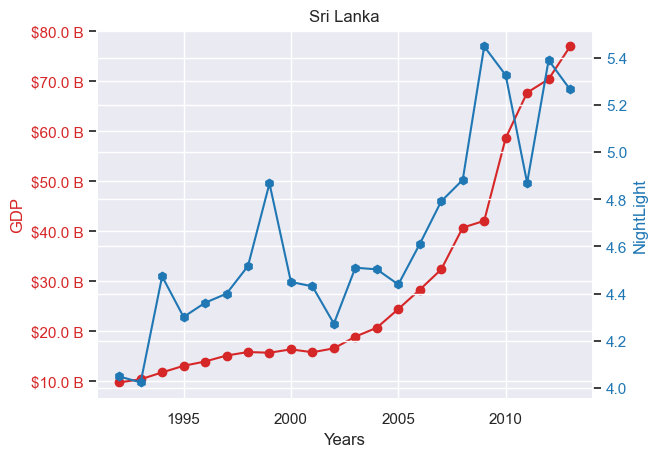

Country India: gdp 279296022987.919 1856722121394.42 | nl 2.953497015447842 4.235561909100194


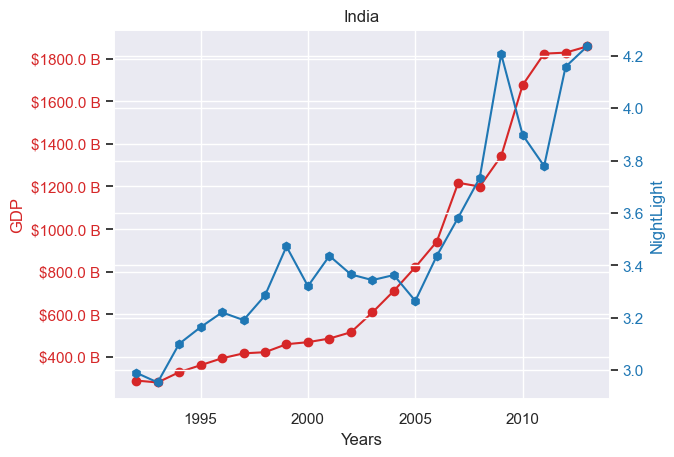

Country Bhutan: gdp 225998091.177435 1781281281.57912 | nl 3.5549817496332627 4.581168587477634


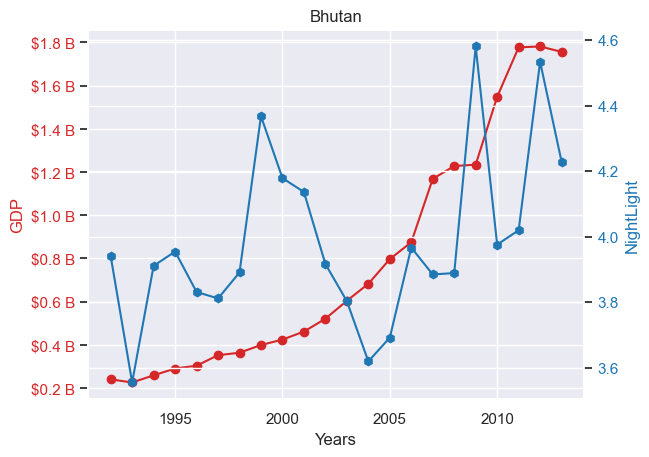

Country Bangladesh: gdp 31708874594.1645 149990451022.29 | nl 4.252737382016613 5.5087167959297405


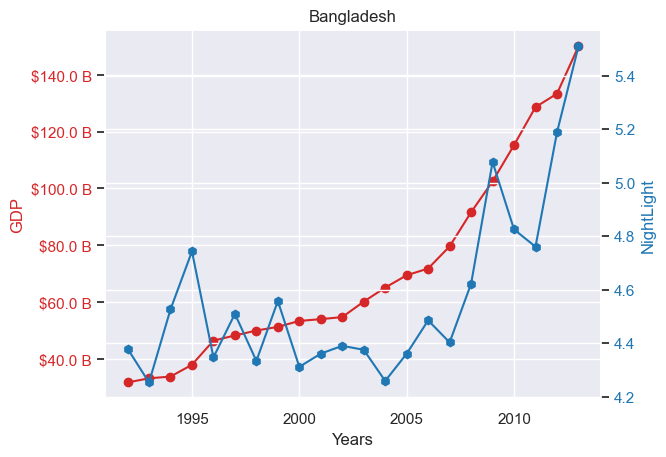

In [35]:
for country in countries_interested:
    cgdp = gdp.loc[country]
    cnl = nl.loc[country]
    
    # print(cnl.head())
    # print(cgdp.head())
    _years = cnl.year.array
    _cnl = cnl.loc[country].nightlight.array
    _cgdp = cgdp.array[1:-8]
    
    print(f"Country {country}: gdp {min(_cgdp)} {max(_cgdp)} | nl {min(_cnl)} {max(_cnl)}")

    plot_(_cnl, _cgdp, _years, country)

In [36]:
# Split the data into training and testing sets

all_years = train_years = list(range(year_start, year_end+1))
train_years = list(range(year_start, (year_end - test_for_year)+1))
test_years = list(range((year_end - test_for_year) + 1, year_end+1))

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[:-1*(test_for_year)]
        break
train_x = np.array(tmp_array) # training set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[:-1*(test_for_year)]
        break
train_y = np.array(tmp_array) # training set y

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[-1*(test_for_year):]
test_x = np.array(tmp_array) # test set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[-1*(test_for_year):]
        break
test_y = np.array(tmp_array) # training set y

# train_xy = np.vstack((train_x, train_y)).T
# test_xy = np.vstack((test_x, test_y)).T


print("All Years:", len(all_years), [all_years[0], all_years[-1]])
print("Train Years:", len(train_years), [train_years[0], train_years[-1]])
print("Test Years:", len(test_years), [test_years[0], test_years[-1]])
print("--"*15)
print("NTL Train:", len(train_x), [train_x[0], train_x[-1]])
print("GDP Train:", len(train_y), [train_y[0], train_y[-1]])
print("--"*8)
print("NTL Test:", len(test_x), [test_x[0], test_x[-1]])
print("GDP Test:", len(test_y), [test_y[0], test_y[-1]])



NameError: name 'year_start' is not defined

In [ ]:
# Train the linear regression model on the training data
model = LinearRegression() #RandomForestRegressor
model2 = RandomForestRegressor()
model.fit(X=train_x.reshape(-1, 1), y=train_y)
model2.fit(X=train_x.reshape(-1, 1), y=train_y)

# Predict the GDP values for the test data
pred_y = model.predict(test_x.reshape(-1, 1)).ravel()
print("Predicted:", len(pred_y), [pred_y[0], pred_y[-1]])
print("Actual:", len(test_y), [test_y[0], test_y[-1]])

# Evaluate the performance of the model
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

all_x = np.concatenate([train_x, test_x])
all_y = np.concatenate([train_y, test_y])

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
ax1.plot(all_years, all_y, marker="s", color='red')
ax1.plot(test_years, pred_y, marker="o", color='orange')
ax1.plot(test_years, test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()


NameError: name 'all_years' is not defined

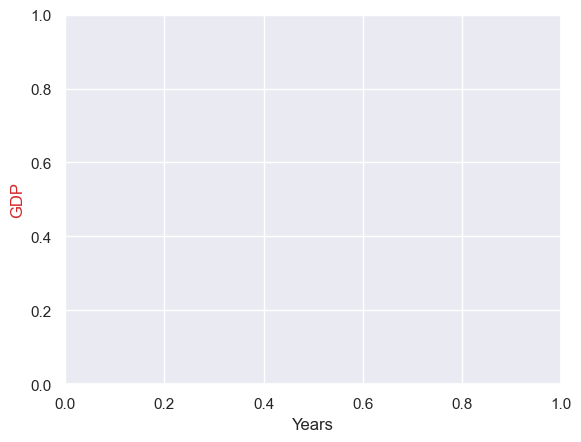

In [37]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP', color=color)
ax1.plot(all_years, all_y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('NightLight', color=color)  # we already handled the x-label with ax1
ax2.plot(all_years, all_x, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()

In [38]:
import seaborn as sns
from scipy.stats import pearsonr

sns.set(style='white')

g = sns.JointGrid(x=train_x, y=train_y)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, kde=False, bins=5, color="xkcd:bluey grey")


NameError: name 'train_x' is not defined

In [39]:
correlation = ps.Series(train_x).corr(ps.Series(train_y))
print("Correlation:", correlation)
plt.plot(train_x, train_y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(train_x, train_y, 1)

#add linear regression line to scatterplot 
plt.plot(train_x, m*train_x+b)
plt.show()

NameError: name 'train_x' is not defined

In [40]:
import statsmodels.api as sm
import matplotlib.animation as animation
from sklearn import datasets, linear_model

# !pip install statsmodels


ModuleNotFoundError: No module named 'statsmodels'

In [41]:
x = sm.add_constant(train_x).astype(float)

mod = sm.OLS(train_x, train_y)
res_v1= mod.fit()
print(res_v1.summary())


mod = sm.OLS(train_x, train_y)
mod = mod.fit()
x_1 = np.arange(2010,2014,1)
x_2 = np.arange(1992,2014,1)

%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
print(mod.predict(test_y).ravel())
ax.scatter(train_x, train_y, color='red', marker='h')
ax.plot(test_x, test_y, color='blue', marker='^')
ax.scatter(mod.predict(test_y).ravel(), test_y, c="orange")
ax.plot(mod.predict(test_y).ravel(), test_y, c="green")

NameError: name 'sm' is not defined

In [42]:
import tensorflow as tf


In [43]:
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=500)


NameError: name 'train_x' is not defined

In [44]:
print(predictions)
print(test_y)
print(test_x)

NameError: name 'predictions' is not defined

NameError: name 'train_years' is not defined

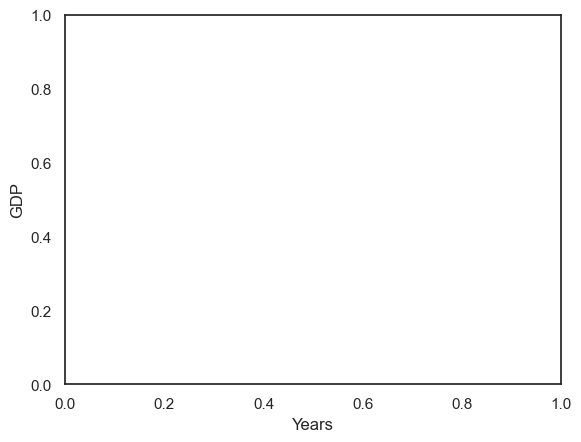

In [45]:
# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
ax1.plot(train_years, train_y, marker="s", color='red')
ax1.plot(test_years, predictions, marker="o", color='orange')
ax1.plot(test_years, test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()

---
# New 

In [48]:
# Show all countries
d = {}
gdp = ps.read_csv(gdp_dataset_filtered, skiprows=0)
nl = ps.read_csv(nightlight, skiprows=0)
gdp = gdp.set_index('Name')
nl = nl.set_index('country')


for country in countries_interested:
    cgdp = gdp.loc[country]
    cnl = nl.loc[country]
    
    _years = cnl.year.array
    _cnl = cnl.loc[country].nightlight.array
    _cgdp = cgdp.array[1:-8]
    _country = ps.array([country for _ in range(len(_cnl))])

    if len(d) == 0:
      d['year'] = _years
      d['country'] = _country
      d['nl'] = _cnl
      d['gdp'] = _cgdp
    else:
      d['year'] = np.append(d['year'], _years)
      d['country'] = np.append(d['country'], _country)
      d['nl'] = np.append(d['nl'], _cnl)
      d['gdp'] = np.append(d['gdp'], _cgdp)
# print(len(d['country']), d['country'])
# print(len(d['nl']), d['nl'])
# print(len(d['gdp']), d['gdp'])

In [70]:
df = ps.DataFrame(d)
sea.set_theme()

# Create a visualization
# sns.relplot(
#     data=nl,
#     x="nightlight", y="year"
# )
sea.relplot(x="yer", y="nl", hue='country', kind="scatter", style="country", col="country", data=df)
# sea.pairplot(x_vars="gdp", y_vars='nl', data=df, hue='country')

plt.show()

ValueError: Could not interpret value `yer` for parameter `x`

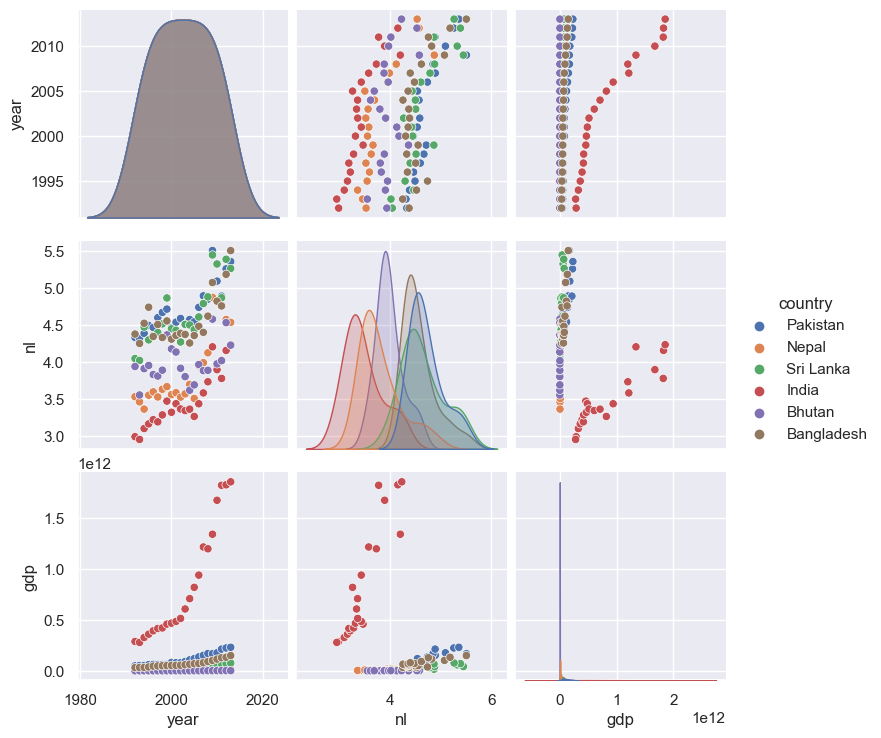

In [65]:
sea.pairplot(data=df, hue='country')
plt.show()